In [2]:
import glob
import os
from pathlib import Path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import xmltodict
from pyproj import Proj
from math import sin, cos
import tqdm
from pyproj import Transformer

import random

In [2]:
def get_distance_point_to_line(point1, point2):
    import math
    x0, y0 = point1
    x1, y1= point2

    # Calculate the distance
    d = math.sqrt((x1-x0)**2 + (y1-y0)**2)

    return d

In [2]:
total_df = pd.DataFrame([],columns=['image','pos_1','pos_2','geo_x','geo_y','iou','field_name'])

In [4]:
def convert_latlon_to_utm(latitude, longitude):
    utm_zone = int((longitude + 180) // 6) + 1  # 计算UTM带号

    utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84', north=True)
    utm_easting, utm_northing = utm_proj(longitude, latitude)

    return utm_easting, utm_northing
def calc_degree(img_pathname):
    def dfm_to_degree(dfm_tuple):
    
        dfm_list = list(dfm_tuple)
        dfm_list = [ float(i) for i in dfm_list ]
        output = 0
        output += dfm_list[0]
        output += dfm_list[1] / 60
        output += dfm_list[2] / 60 / 60
        
        return output

    img = Image.open(img_pathname)
    info = img._getexif()

    N = info[34853][2]
    E = info[34853][4]
    H = info[34853][6]

    N_d = dfm_to_degree(N)
    E_d = dfm_to_degree(E)
    return N_d, E_d


def calc_scalc(image_width, image_height):
    # 相机参数
    focal_length = 35  # 焦距为35毫米
    sensor_width = 35.9  # 传感器宽度为24毫米
    sensor_height = 24  # 传感器高度为18毫米


    # 计算视野范围
    distance = 15  # 相机到被拍摄物体的距离

    # 计算比例尺
    xscale = (sensor_width * distance ) / (image_width * focal_length)
    yscale = (sensor_height * distance ) / (image_height * focal_length)


    return xscale, yscale

def getFlightYawDegree(img_pathname):
    with open(img_pathname, 'rb') as f:
        f.seek(0)
        byte_data = f.read(100000)

    text = ''

    for b in byte_data:
        try:
            text += b.to_bytes(1, 'big').decode('utf-8')
        except :
            pass

    text = text[text.find('<?xpacket'):text.find('</x:xmpmeta>')+len('</x:xmpmeta>')]
    data = xmltodict.parse(text)
    FlightYawDegree = data['x:xmpmeta']['rdf:RDF']['rdf:Description']['@drone-dji:FlightYawDegree']
    
    return FlightYawDegree

def Projection2ImageRowCol(adfGeoTransform, dProjX, dProjY):


    dTemp = adfGeoTransform[1] * adfGeoTransform[5] - \
        adfGeoTransform[2] * adfGeoTransform[4]

    dCol = (adfGeoTransform[5] * (dProjX - adfGeoTransform[0]) -
            adfGeoTransform[2] * (dProjY - adfGeoTransform[3])) / dTemp + 0.5

    dRow = (adfGeoTransform[1] * (dProjY - adfGeoTransform[3]) -
            adfGeoTransform[4] * (dProjX - adfGeoTransform[0])) / dTemp + 0.5

    return [ int(dCol), int(dRow) ]



def calc_yaw_x_y(yaw_world,dProjX,dProjY):
        # 顺时针针转
        R = [[cos(yaw_world), sin(yaw_world)], 
             [sin(yaw_world), cos(yaw_world)]] 
        x_new = R[0][0] * dProjX + R[0][1] * dProjY 
        y_new = - R[1][0] * dProjX + R[1][1] * dProjY
        return  x_new,y_new
def rotate_image(image, angle):
    errors = -3.5

    # 获取图像尺寸
    height, width = image.shape[:2]

    # 设置旋转中心
    center = (width // 2, height // 2)

    # 计算旋转矩阵
    rotation_matrix = cv2.getRotationMatrix2D(center, angle + errors, 1)

    # 计算旋转后的新尺寸
    radians = np.radians(angle)
    sin = np.sin(radians)
    cos = np.cos(radians)
    new_width = int((height * np.abs(sin)) + (width * np.abs(cos)))
    new_height = int((height * np.abs(cos)) + (width * np.abs(sin)))

    # 更新旋转矩阵的平移量
    rotation_matrix[0, 2] += (new_width // 2) - center[0]
    rotation_matrix[1, 2] += (new_height // 2) - center[1]

    # 进行仿射变换
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height))

    return rotated_image



In [4]:
tasks_list = [
    '/home/neau/sdb/mmyolo/leaf_result/航拍2/*.txt',
    '/home/neau/sdb/mmyolo/leaf_result/航拍3/*.txt'
]


for tasks in tasks_list:
    leafs = 0
    for task in tqdm.tqdm(glob.glob(tasks)):
        # img = cv2.imread(image_pathname)
        name = Path(task).name.split('.')[0]
        field_name = task.split('/')[-2]
        
        img_pathname = os.path.join('/home/neau/sdb/datasets/7.8-80亩-可见光/*/',name+'.JPG')
        img_pathname = glob.glob(img_pathname)[0]
        img = cv2.imread(img_pathname)
        
        height, width, _ = img.shape
        xscale, yscale = calc_scalc(width, height)

        utm_center_x, utm_center_y = convert_latlon_to_utm( *calc_degree(img_pathname))
        utm_left_top = ( utm_center_x - (width / 2) * xscale, utm_center_y + (height / 2) * yscale )
        with open(task) as fs:
            lines = fs.readlines()
            lines = [lines[i].split(' ') for i in range(len(lines))]
            for i in range(len(lines)):
                line = lines[i][0:-1]
                line = [float(i) for i in line]
                label = int(line[0])
                iou = float(line[1])
                pos_1 = [int(line[2]), int(line[3])]
                pos_2 = [int(line[4]), int(line[5])]

                x_center = line[2] + (line[4] - line[2])/2
                y_center = line[3] + (line[5] - line[3])/2
                x = utm_left_top[0] + int(x_center) * xscale
                y = utm_left_top[1] - int(y_center) * yscale
                
                
                if iou > 0.7 and label == 0:
                    leafs += 1
                    
                    exp_num = 30
                    
                    df = pd.DataFrame([{
                        'image':name,
                        'pos_1':','.join([str(i) for i in pos_1]),
                        'pos_2':','.join([str(i) for i in pos_2]),
                        'geo_x': x,
                        'geo_y': y,
                        'iou':iou,
                        'field_name':field_name
                    }])
                    
                    total_df = pd.concat([total_df,df],ignore_index=True)
                
                    exp_num = 30
                    # img_leaf = img[pos_1[1] - exp_num : pos_2[1] + exp_num,pos_1[0] - exp_num:pos_2[0] + exp_num]
                    # img_leaf = img[pos_1[1]:pos_2[1],pos_1[0]:pos_2[0]]
                    # cv2.imwrite(f'leaf_result/img-leaf-{leafs}.jpg', img_leaf)

    print(tasks,leafs)
    
total_df.to_csv('total_df.csv')

100%|██████████| 645/645 [17:36<00:00,  1.64s/it]


/home/neau/sdb/mmyolo/leaf_result/航拍2/*.txt 135121


100%|██████████| 682/682 [11:55<00:00,  1.05s/it]

/home/neau/sdb/mmyolo/leaf_result/航拍3/*.txt 6732


### 去除重叠率和单株上附近的杂株

In [11]:
total_cp = pd.read_csv('total_df.csv')
total_cp = total_cp[total_cp['iou']>0.8]
index = 0
d = 2

while index <= (total_cp.shape[0] - 1):
    cell = total_cp[['geo_x','geo_y']].iloc[index]
    c_utm_x_c = cell['geo_x']
    c_utm_y_c = cell['geo_y']
    
    
    temp = []
    for j in range(index + 1, total_cp.shape[0]):
        line = total_cp[['geo_x','geo_y']].iloc[j]
        n = line.name
        c_utm_x_i = line['geo_x']
        c_utm_y_i = line['geo_y']        
        if get_distance_point_to_line((c_utm_x_c,c_utm_y_c),(c_utm_x_i,c_utm_y_i)) < d:
            temp.append(n)
            
            
    total_cp = total_cp.drop(temp)
    index += 1
    print(index,total_cp.shape[0], index/total_cp.shape[0] * 100)

1 16880 0.0059241706161137445
2 16870 0.011855364552459988
3 16856 0.01779781680113906
4 16832 0.02376425855513308
5 16823 0.029721215003269335
6 16817 0.035678182791223166
7 16807 0.04164931278633903
8 16801 0.047616213320635675
9 16797 0.05358099660653688
10 16792 0.05955216769890424
11 16788 0.06552299261377174
12 16785 0.07149240393208221
13 16776 0.07749165474487363
14 16776 0.08345255126371007
15 16768 0.08945610687022901
16 16767 0.09542553825967674
17 16767 0.10138963440090654
18 16759 0.10740497643057462
19 16752 0.11341929321872016
20 16740 0.11947431302270012
21 16737 0.12547051442910914
22 16731 0.13149243918474687
23 16727 0.13750224188437854
24 16724 0.1435063381966037
25 16722 0.1495036478890085
26 16719 0.15551169328309108
27 16719 0.16149291225551768
28 16718 0.16748414882162938
29 16711 0.17353838788821735
30 16709 0.17954395834580167
31 16707 0.18555096666068116
32 16698 0.19163971733141694
33 16681 0.19782986631496913
34 16669 0.20397144399784028
35 16663 0.21004621

In [ ]:
total_cp.to_csv('total_df_del-iou0.8-2m.csv')

# 生成可视化杂株图像

In [45]:
for name,row in tqdm.tqdm(total_cp.iterrows()):
    pos_1 = [int(i) for i in row['pos_1'].split(',')]
    pos_2 = [int(i) for i in row['pos_2'].split(',')]
    field_name = row['field_name']
    image_name = row['image']
    img_pathname = glob.glob(os.path.join('/home/neau/sdb/datasets/7.8-80亩-可见光/*/',image_name+'.JPG'))[0]
    img = cv2.imread(img_pathname)
    

    
    exp_num = 100
    img_leaf = img[pos_1[1] - exp_num : pos_2[1] + exp_num,pos_1[0] - exp_num:pos_2[0] + exp_num]
    if 0 in img_leaf.shape:
        continue
    img = cv2.rectangle(img, pos_1, pos_2, (0,0,255), 2)


    cv2.imwrite(f'leaf_result/{field_name}-filtrate/{name}.jpg', img_leaf)

4656it [1:01:25,  1.26it/s]


# 杂株分布图像

100%|██████████| 682/682 [00:01<00:00, 560.46it/s]


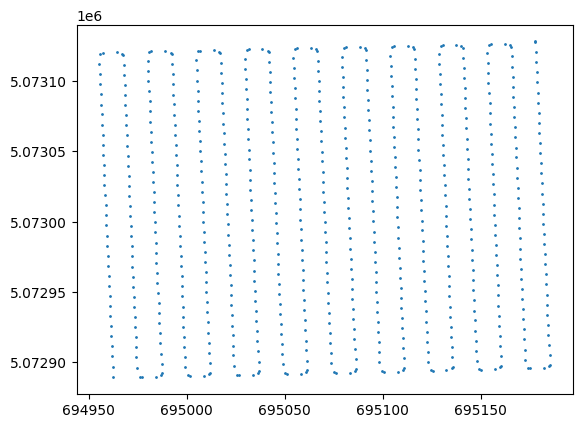

In [20]:
geo_list = []
# img_list = glob.glob(os.path.join('/home/neau/sdb/datasets/7.8-80亩-可见光/DJI_202307081100_028_新建建图航拍3/*.JPG')) + \
#            glob.glob(os.path.join('/home/neau/sdb/datasets/7.8-80亩-可见光/DJI_202307081148_029_新建建图航拍3/*.JPG'))
           
img_list = glob.glob(os.path.join('/home/neau/sdb/datasets/7.8-80亩-可见光/DJI_202307080820_026_新建建图航拍2-副本/*.JPG')) + \
           glob.glob(os.path.join('/home/neau/sdb/datasets/7.8-80亩-可见光/DJI_202307081100_027_新建建图航拍2-副本/*.JPG'))
           
                    
    

for pathname in tqdm.tqdm(img_list):
    name = Path(pathname).name[:-4]
    utm_center_x, utm_center_y = convert_latlon_to_utm( *calc_degree(pathname))
    geo_list.append([utm_center_x, utm_center_y])

geo_np = np.array(geo_list)
plt.scatter(geo_np[:,0],geo_np[:,1],s=1)

In [16]:
ms_name_list =[]
for pathname in tqdm.tqdm(glob.glob(os.path.join('/home/neau/sdb/mmyolo/leaf_result/航拍2-filtrate-del/*.jpg'))):
    name = Path(pathname).name[:-4]
    ms_name_list.append(name)

ms_img_name = set()
df = pd.read_csv('total_df.csv')
for ms in ms_name_list:
    ms_img_name.add(df.loc[int(ms)]['image'])

ms_list = []

for ms_name in ms_img_name:
    img_pathname = glob.glob(os.path.join('/home/neau/sdb/datasets/7.8-80亩-可见光/*/',ms_name+'.JPG'))[0]
    utm_center_x, utm_center_y = convert_latlon_to_utm( *calc_degree(img_pathname))
    ms_list.append([utm_center_x, utm_center_y])
    
    

100%|██████████| 74/74 [00:00<00:00, 78319.08it/s]


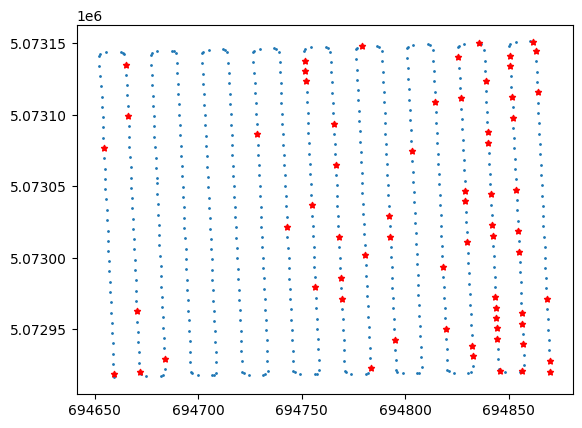

In [17]:
ms_np = np.array(ms_list)


plt.scatter(geo_np[:,0],geo_np[:,1],s=1)
plt.scatter(ms_np[:,0],ms_np[:,1],s=20,c='r',marker=(5,1))

# 生成表格

In [10]:
ms_name_list = [int(i) for i in ms_name_list]
df = pd.read_csv('total_df.csv')

ms_df = df.loc[ms_name_list][['geo_x','geo_y']]
ms_df = pd.concat([ms_df,pd.DataFrame([],columns=['latitude', 'longitude'])],axis=1)


transformer = Transformer.from_crs("epsg:32649", "epsg:4326")
for name,row in ms_df.iterrows():
    x = float(row['geo_x'])
    y = float(row['geo_y'])
    lat, lon = transformer.transform(x, y)
    ms_df.loc[name,'latitude'] = lat
    ms_df.loc[name,'longitude'] = lon



ms_df.to_excel('东升一号.xlsx')

## 输出JSON格式

In [5]:
import json
import datetime
import time

def time_to_utc(year,month,day,h,m,s):
    timestamp = datetime.datetime(year, month, day, h, m, s).replace(tzinfo=datetime.timezone.utc).timestamp()
    dt = datetime.datetime.fromtimestamp(timestamp, tz=datetime.timezone.utc)
    return str(dt)


In [31]:
output_df = pd.read_excel('东升一号.xlsx')

In [34]:
output_df

,Unnamed: 0,geo_x,geo_y,latitude,longitude
0,135171,694956.534163,5.072903e+06,45.782156,113.507964
1,135191,694961.769156,5.072911e+06,45.782223,113.508034
2,135193,694955.734696,5.072907e+06,45.782196,113.507956
3,135233,694968.962188,5.072927e+06,45.782366,113.508133
4,135255,694961.933605,5.072933e+06,45.782426,113.508046
...,...,...,...,...,...
150,141299,695138.319002,5.072918e+06,45.782241,113.510306
151,141411,695134.634577,5.072932e+06,45.782363,113.510264
152,141604,695125.116729,5.072894e+06,45.782030,113.510127
153,141620,695128.993884,5.072897e+06,45.782054,113.510178


In [59]:
flight_range = 80
hybrid_plant_num = output_df.shape[0]
img_inference_num = 645
plant_num = 50 / 0.9 * 666 * flight_range

purity = 1 - round(hybrid_plant_num / plant_num , 8)
purity_type = ["round_leaf", "white_flower"]
project_name = "855-东升一号"


end_time = time_to_utc(2023,7,23,1,22,34) 
create_time = time_to_utc(2023,7,22,11,1,54)

flight_start_date = time_to_utc(2023,7,21,12,22,34)
flight_end_date = time_to_utc(2023,7,21,15,5,31)

hybrid_plants = []
for name,row in output_df.iterrows():
    id = int(row['Unnamed: 0'])
    
    hybrid_plants.append({
            "id":id,
            "type": "round_leaf" ,
            "iou": round(0.80 + random.randint(0,1000)/10000,4),
            "latitude": row['latitude'],
            "longitude": row['longitude'],
            "path": f"images/{id}"
        })

In [60]:
output_dic = {
    "project_name" : project_name,
    "hybrid_plant_num": hybrid_plant_num,
    "img_inference_num": img_inference_num,
	"end_time":"2023-07-22T11:01:54.123Z",
	"create_time":"2023-07-23T01:22:34.221Z",
	"purity":purity,
	"flight_start_date":"2023-07-23T01:22:34.221Z",
	"flight_end_date":"2023-07-23T01:22:34.221Z",
	"flight_range": flight_range,
	"purity_type":purity_type,
	"plant_num": plant_num,
    "hybrid_plants" : hybrid_plants
}


In [61]:
output_dic

{'project_name': '855-东升一号',
 'hybrid_plant_num': 155,
 'img_inference_num': 645,
 'end_time': '2023-07-22T11:01:54.123Z',
 'create_time': '2023-07-23T01:22:34.221Z',
 'purity': 0.99994764,
 'flight_start_date': '2023-07-23T01:22:34.221Z',
 'flight_end_date': '2023-07-23T01:22:34.221Z',
 'flight_range': 80,
 'purity_type': ['round_leaf', 'white_flower'],
 'plant_num': 2960000.0,
 'hybrid_plants': [{'id': 135171,
   'type': 'round_leaf',
   'iou': 0.8504,
   'latitude': 45.78215638504209,
   'longitude': 113.5079640202307,
   'path': 'images/135171'},
  {'id': 135191,
   'type': 'round_leaf',
   'iou': 0.8123,
   'latitude': 45.78222346660459,
   'longitude': 113.5080343752315,
   'path': 'images/135191'},
  {'id': 135193,
   'type': 'round_leaf',
   'iou': 0.8368,
   'latitude': 45.78219594934851,
   'longitude': 113.5079555106179,
   'path': 'images/135193'},
  {'id': 135233,
   'type': 'round_leaf',
   'iou': 0.8597,
   'latitude': 45.78236599765795,
   'longitude': 113.5081333048666

In [63]:
import json
json_str = json.dumps(output_dic)
with open('output.json', 'w') as json_file:
    json_file.write(json_str)

In [22]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

def get_image_metadata(image_path):
    """Retrieve metadata from an image."""
    image = Image.open(image_path)
    
    # Extract the exif data (if it exists)
    image_info = image._getexif()

    
    return image_info





In [19]:
datetime.now()

datetime.datetime(2023, 8, 9, 6, 36, 0, 580825)

In [23]:
datetime.strptime(get_image_metadata('/home/neau/sdb/mmyolo/855-SPNet/test_images/DJI_20230708083535_0001.JPG')[306], '%Y:%m:%d %H:%M:%S')

datetime.datetime(2023, 7, 8, 8, 35, 35)

In [25]:
datetime_list = [
    datetime(2023, 7, 8, 8, 35, 35),
    datetime(2021, 5, 5, 5, 5, 5),
    datetime(2022, 6, 6, 6, 6, 6),
    datetime(2020, 4, 4, 4, 4, 4)
]
max(datetime_list)


datetime.datetime(2023, 7, 8, 8, 35, 35)

In [27]:
import os
os.getcwd()

'/home/neau/sdb/mmyolo'